In [ ]:
%pip install scikit-learn --quiet

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier , RandomForestClassifier


▶ Loading training data…
▶ Loading test data…
Training samples: 4080 | Test samples: 1458
▶ Training custom SVM model…

Accuracy on test data: 79.63%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       1.00      0.50      0.67         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         1
           8       1.00      0.50      0.67         2
           9       1.00      0.33      0.50         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14   

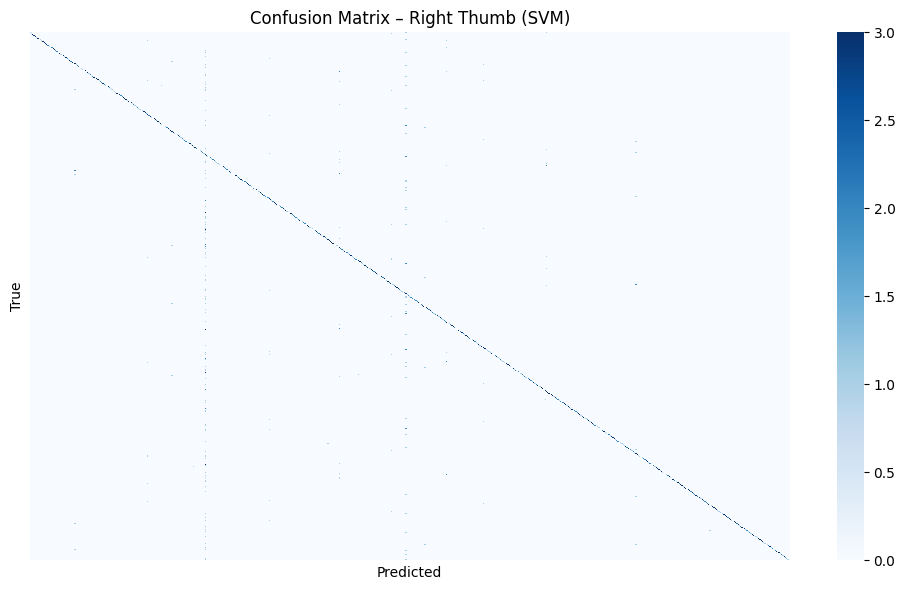

In [ ]:
IMAGE_SIZE = (128, 128)
HOG_SIZE = (64, 128)
CELL_SIZE = 8
NBINS = 9

TRAIN_PATHS = r"C:\Users\hllag\Downloads\archive\SOCOFing\Train"
TEST_PATHS = r"C:\Users\hllag\Downloads\archive\SOCOFing\test"

def extract_hog_features(image):
    image = cv2.resize(image, HOG_SIZE)
    dx = cv2.Sobel(np.float32(image), cv2.CV_64F, 1, 0, ksize=1)
    dy = cv2.Sobel(np.float32(image), cv2.CV_64F, 0, 1, ksize=1)
    magnitude = np.sqrt(dx**2 + dy**2)
    orientation = np.rad2deg(np.arctan2(dy, dx)) % 180
    bin_size = 180 // NBINS
    h, w = image.shape
    n_cells_x = w // CELL_SIZE
    n_cells_y = h // CELL_SIZE
    feature_vector = []
    for i in range(n_cells_y):
        for j in range(n_cells_x):
            mag_cell = magnitude[i*CELL_SIZE:(i+1)*CELL_SIZE, j*CELL_SIZE:(j+1)*CELL_SIZE]
            ori_cell = orientation[i*CELL_SIZE:(i+1)*CELL_SIZE, j*CELL_SIZE:(j+1)*CELL_SIZE]
            hist = np.zeros(NBINS)
            for y in range(CELL_SIZE):
                for x in range(CELL_SIZE):
                    mag = mag_cell[y, x]
                    angle = ori_cell[y, x]
                    bin_idx = int(angle // bin_size) % NBINS
                    hist[bin_idx] += mag
            feature_vector.extend(hist)
    return np.array(feature_vector)

def load_hog_dataset(folders):
    X = []
    y = []
    for folder in folders:
        for fname in os.listdir(folder):
            if not fname.lower().endswith(".bmp"):
                continue
            if "right_thumb" not in fname.lower():
                continue
            person_id = fname.split("__")[0].strip()
            fpath = os.path.join(folder, fname)
            img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, IMAGE_SIZE)
            hog_feat = extract_hog_features(img)
            X.append(hog_feat)
            y.append(person_id)
    return np.array(X), np.array(y)

print("▶ Loading training data…")
X_train, y_train = load_hog_dataset([TRAIN_PATHS]) 

print("▶ Loading test data…")
X_test, y_test = load_hog_dataset([TEST_PATHS])     


unique_labels = sorted(list(set(y_train)))
label_map = {label: idx for idx, label in enumerate(unique_labels)}
y_train_encoded = np.array([label_map[label] for label in y_train])


y_test_encoded = np.array([label_map.get(label, -1) for label in y_test])
valid_idx = y_test_encoded != -1
X_test = X_test[valid_idx]
y_test_encoded = y_test_encoded[valid_idx]

print(f"Training samples: {len(X_train)} | Test samples: {len(X_test)}")

class LinearSVM:
    def __init__(self, lr=0.0001, C=1.0, epochs=1000):
        self.lr = lr
        self.C = C
        self.epochs = epochs

    def fit(self, X, y):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        self.classes = np.unique(y)
        self.weights = np.zeros((n_classes, n_features))
        self.bias = np.zeros(n_classes)

        for epoch in range(self.epochs):
            for idx, x_i in enumerate(X):
                for c in self.classes:
                    y_true = 1 if y[idx] == c else -1
                    condition = y_true * (np.dot(self.weights[c], x_i) + self.bias[c])
                    if condition < 1:
                        self.weights[c] += self.lr * (y_true * x_i + -2 * self.C * self.weights[c])
                        self.bias[c] += self.lr * y_true
                    else:
                        self.weights[c] += self.lr * (-2 * self.C * self.weights[c])

    def predict(self, X):
        scores = np.dot(X, self.weights.T) + self.bias
        return np.argmax(scores, axis=1)

print("▶ Training custom SVM model…")
svm = LinearSVM(lr=0.00001, C=0.1, epochs=1000)
svm.fit(X_train, y_train_encoded)

y_pred = svm.predict(X_test)
acc = accuracy_score(y_test_encoded, y_pred)
print(f"\nAccuracy on test data: {acc * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred, zero_division=1))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test_encoded, y_pred), cmap="Blues", xticklabels=False, yticklabels=False)
plt.title("Confusion Matrix – Right Thumb (SVM)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [23]:
#edict single image
def predict_new_fingerprint(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Image not found.")
        return
    img = cv2.resize(img, IMAGE_SIZE)
    hog_feat = extract_hog_features(img).reshape(1, -1)
    pred_encoded = svm.predict(hog_feat)[0]
    reverse_map = {v: k for k, v in label_map.items()}
    print("Predicted Person ID:", reverse_map[pred_encoded])
predict_new_fingerprint(
    r"C:\Users\hllag\Downloads\archive\SOCOFing\test\153__M_Right_thumb_finger_Zcuthard.BMP"
)
# Example usage:
# predict_new_fingerprint(r"C:\Users\hllag\Downloads\archive\SOCOFing\test\hard\1__M_Right_thumb_finger_Obl.BMP")

Predicted Person ID: 153


In [ ]:
print("\n▶ Training Scikit-learn Linear SVM model…")
sklearn_svm = LinearSVC(max_iter=10000)
sklearn_svm.fit(X_train, y_train_encoded)
y_pred_sklearn_svm = sklearn_svm.predict(X_test)

acc_svm_sklearn = accuracy_score(y_test_encoded, y_pred_sklearn_svm)
print(f"Scikit-learn Linear SVM Accuracy: {acc_svm_sklearn * 100:.2f}%")
print("Classification Report (Scikit-learn Linear SVM):")
print(classification_report(y_test_encoded, y_pred_sklearn_svm, zero_division=1))



print("\n▶ Training KNN model…")
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train_encoded)
y_pred_knn = knn.predict(X_test)

acc_knn = accuracy_score(y_test_encoded, y_pred_knn)
print(f"KNN Accuracy: {acc_knn * 100:.2f}%")
print("Classification Report (KNN):")
print(classification_report(y_test_encoded, y_pred_knn, zero_division=1))



print("\n▶ Training Random Forest model…")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train_encoded)
y_pred_rf = rf.predict(X_test)

acc_rf = accuracy_score(y_test_encoded, y_pred_rf)
print(f"Random Forest Accuracy: {acc_rf * 100:.2f}%")
print("Classification Report (Random Forest):")
print(classification_report(y_test_encoded, y_pred_rf, zero_division=1))

print("\n=== Summary of Accuracies ===")
print(f"Custom Linear SVM:     {acc * 100:.2f}%")
print(f"Scikit-learn Linear SVM: {acc_svm_sklearn * 100:.2f}%")
print(f"KNN:                   {acc_knn * 100:.2f}%")
print(f"Random Forest:         {acc_rf * 100:.2f}%")


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.

▶ Training Scikit-learn Linear SVM model…
Scikit-learn Linear SVM Accuracy: 99.93%
Classification Report (Scikit-learn Linear SVM):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         2
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00 